In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

# Set initial seed for random sampling
rng = np.random.default_rng(5731)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load in dataset and sort by dispersion velocity
data = pd.read_csv('zaw_table_4.csv').sort_values(by=['sigma'])

# Divide by factor of 200 to scale velocity dispersion according to paper
data['sigma'] /= 200 
data['e_sigma'] /= 200

# Multiply by factor of 10^7 to scale black hole mass according to paper
data['MassBH'] *= 1E7 
data['E_MassBH'] *= 1E7
data['e_MassBH'] *= 1E7

# Set up intercept
data['Intercept'] = np.ones(data['Name'].count())
data['e_Intercept'] = np.ones(data['Name'].count())*1e-2

# Convert to log velocity dispersion and keep only the largest log error
data['log_sigma'] = np.log10(data['sigma'])
data['e_log_sigma_upper'] = np.log10(1 + data['e_sigma']/data['sigma'])
data['e_log_sigma_lower'] = -np.log10(1 - data['e_sigma']/data['sigma'])
data['e_log_sigma'] = data[['e_log_sigma_upper', 'e_log_sigma_lower']].max(axis=1)

# Compute square of log velocity dispersion and propagate (gaussian) error
data['log_sigma^2'] = np.log10(data['sigma'])**2
data['e_log_sigma^2'] = 2*np.abs(data['log_sigma'])*data['e_log_sigma']

# Convert to log black hole mass and keep only the largest log error
data['log_MassBH'] = np.log10(data['MassBH'])
data['e_log_MassBH_upper'] = np.log10(1 + data['E_MassBH']/data['MassBH'])
data['e_log_MassBH_lower'] = -np.log10(1 - data['e_MassBH']/data['MassBH'])
data['e_log_MassBH'] = data[['e_log_MassBH_upper', 'e_log_MassBH_lower']].max(axis=1)

# Set up response and error for linear model
X_l = np.array(data[['Intercept', 'log_sigma']])
X_l_err = np.array(data[['e_Intercept', 'e_log_sigma']])

# Set up response and error for quadratic model
X_q = np.array(data[['Intercept', 'log_sigma', 'log_sigma^2']])
X_q_err = np.array(data[['e_Intercept', 'e_log_sigma', 'e_log_sigma^2']])

# Set up covariate and error for both models
Y = np.array(data['log_MassBH'])
Y_err = np.array(data['e_log_MassBH'])

### Errorbar Plot of Dataset

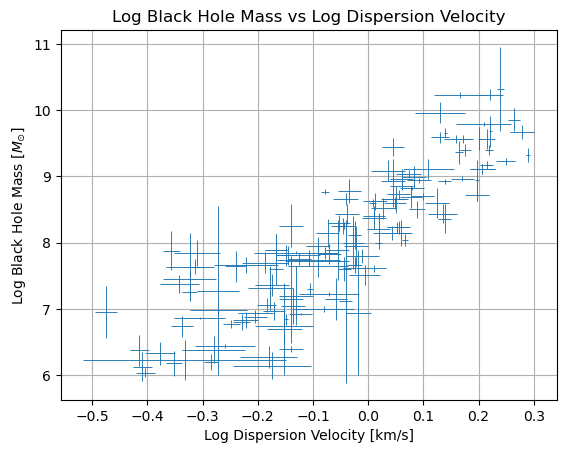

In [3]:
# Plot the log black hole mass vs log dispersion velocity with errorbars
plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)
plt.title('Log Black Hole Mass vs Log Dispersion Velocity')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Linear Regression with Measurement Error

In [4]:
# Bayesian linear regression model incorporating measurement error
def linear_regression(X, Y, X_std, Y_std, c=1e-3, d=1e-3, e=0.5, f=0.5, samples=10000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma'],
    }
    
    with pm.Model(coords=coords):
        tau = pm.Gamma('tau', alpha=e, beta=f)
        betas = pm.Normal('beta', mu=0, tau=d, dims='parameters')
        X_true = pm.Normal('X_true', mu=0, tau=c, dims=['galaxy', 'parameters'])
        X_obs = pm.Normal('X_obs', mu=X_true, sigma=X_std, observed=X)
        mu = pm.Deterministic('mu', X_obs @ betas)
        Y_true = pm.Normal('Y_true', mu=mu, tau=tau)
        Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=Y_std, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 92 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

<Figure size 640x480 with 0 Axes>

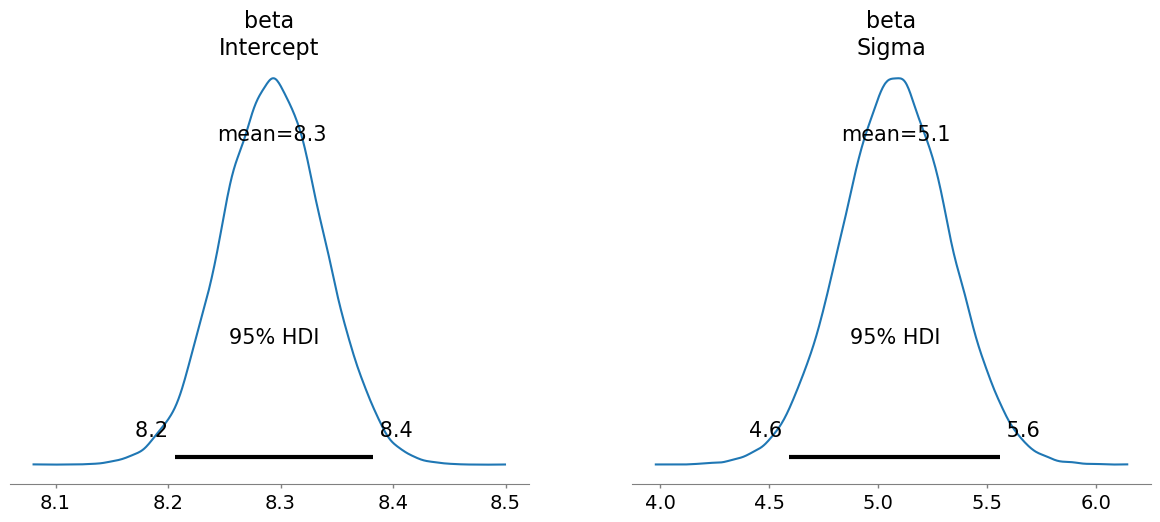

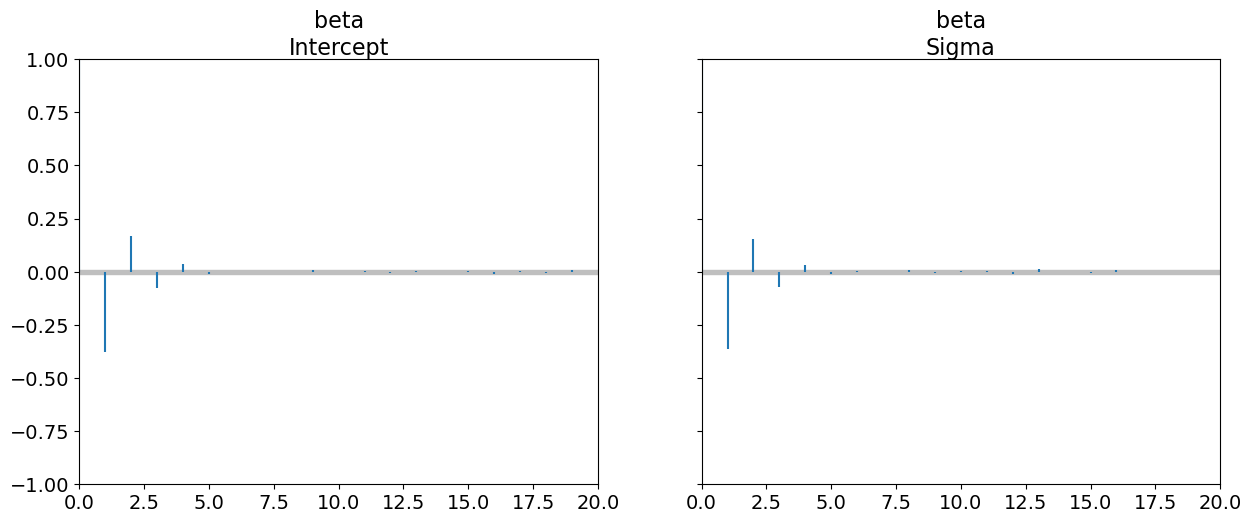

In [5]:
# Apply the linear regression model for standard reference priors
l_trace, l_prior_pred, l_post_pred = linear_regression(X_l, Y, X_l_err, Y_err)

# Show table of results for the linear regression model
pm.summary(l_trace)

# Plot beta posterior distributions and autocorrelations
plt.figure()
az.plot_posterior(l_trace, var_names='beta', hdi_prob=0.95)
az.plot_autocorr(l_trace, var_names='beta', max_lag=20, combined=True)
plt.show()

# Quadratic Regression with Measurement Error

In [6]:
# Bayesian quadratic regression model incorporating measurement error
def quadratic_regression(X, Y, X_std, Y_std, c=1e-3, d=1e-3, e=0.5, f=0.5, samples=10000, draws=50):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma', 'Sigma^2'],
    }

    with pm.Model(coords=coords):
        tau = pm.Gamma('tau', alpha=e, beta=f)
        betas = pm.Normal('beta', mu=0, tau=d, dims='parameters')
        X_true = pm.Normal('X_true', mu=0, tau=c, dims=['galaxy', 'parameters'])
        X_obs = pm.Normal('X_obs', mu=X_true, sigma=X_std, observed=X)
        mu = pm.Deterministic('mu', X_obs @ betas)
        Y_true = pm.Normal('Y_true', mu=mu, tau=tau)
        Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=Y_std, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        prior_pred = pm.sample_prior_predictive(draws=draws, random_seed=rng)
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)
        return trace, prior_pred, post_pred

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 103 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

<Figure size 640x480 with 0 Axes>

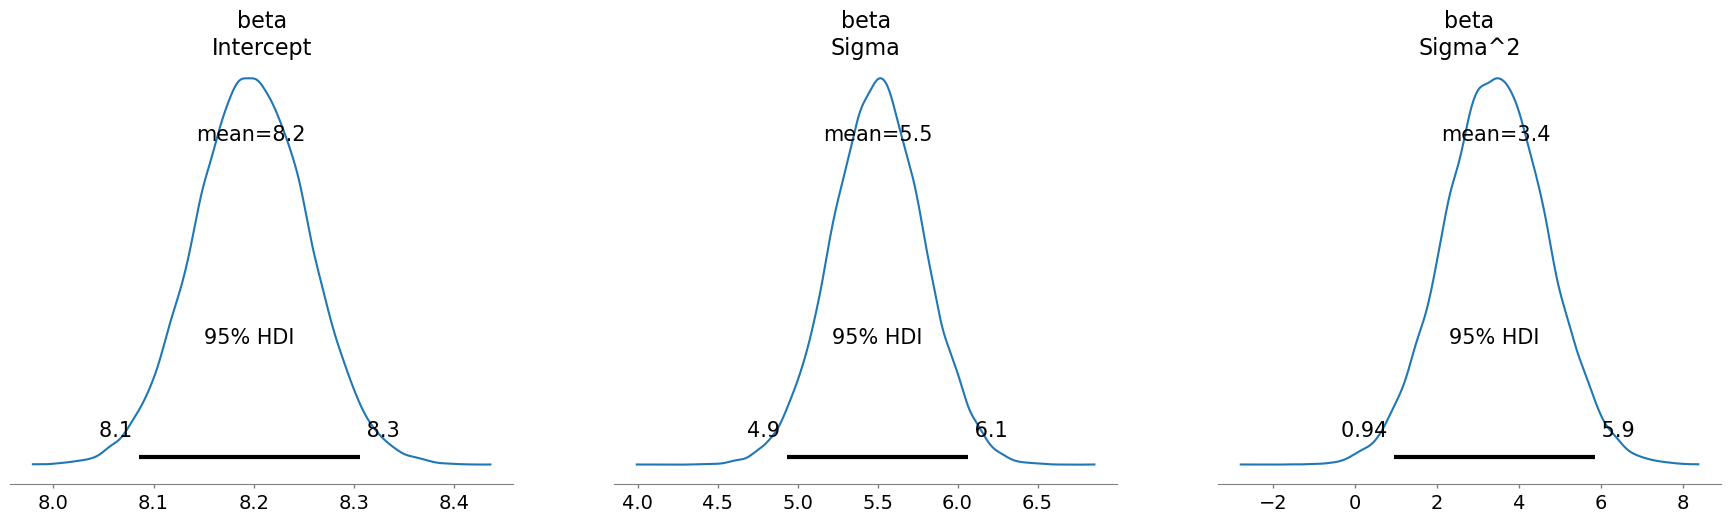

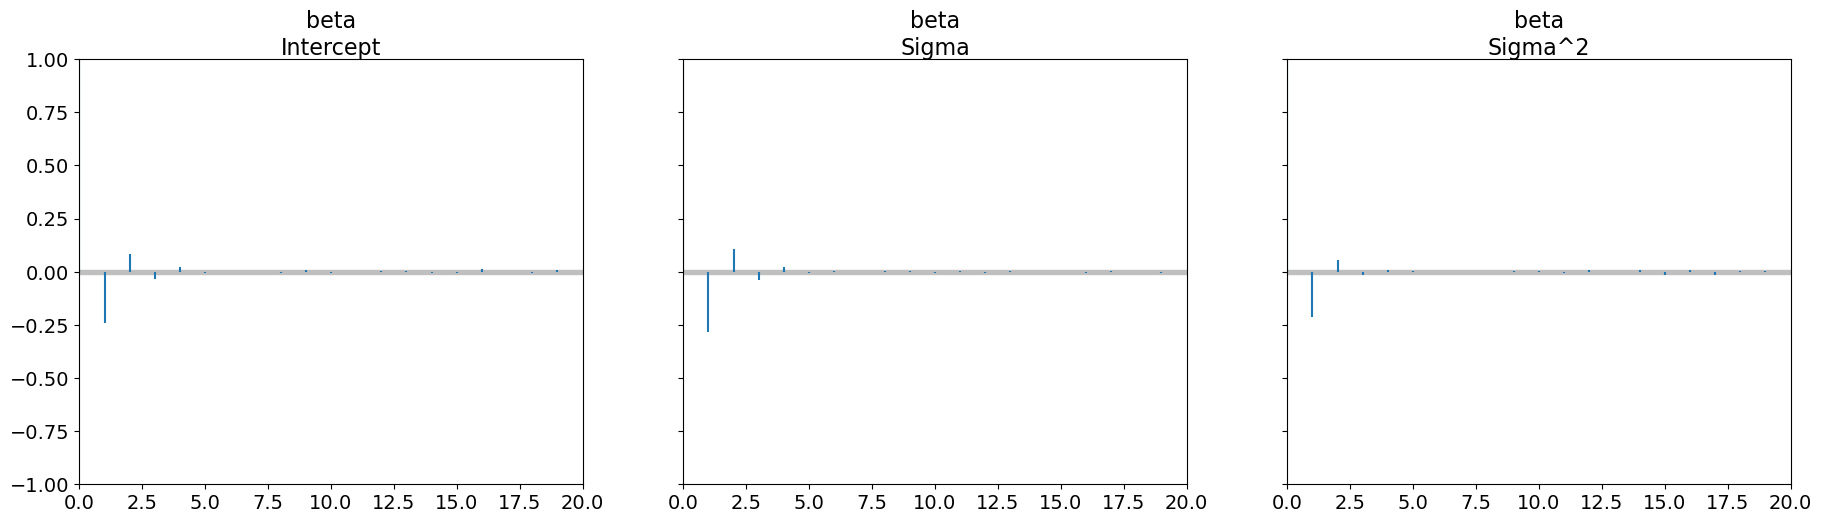

In [7]:
# Apply the quadratic regression model for standard reference priors
q_trace, q_prior_pred, q_post_pred = quadratic_regression(X_q, Y, X_q_err, Y_err)

# Show table of results for the quadratic regression model
pm.summary(q_trace)

# Plot beta posterior distributions and autocorrelations
plt.figure()
az.plot_posterior(q_trace, var_names='beta', hdi_prob=0.95)
az.plot_autocorr(q_trace, var_names='beta', max_lag=20, combined=True)
plt.show()

# Posterior Plot

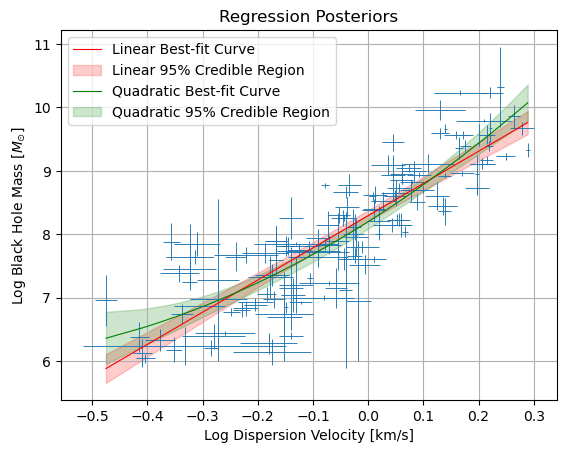

In [8]:
plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)

# Calculate quantiles for posterior black hole mass for linear regression
Y_l_mean = np.quantile(l_trace.posterior.mu.values, 0.50, axis=(0, 1))
Y_l_lower = np.quantile(l_trace.posterior.mu.values, 0.025, axis=(0, 1))
Y_l_upper = np.quantile(l_trace.posterior.mu.values, 0.975, axis=(0, 1))

# Plot mean and 95% confidence interval of posterior for linear regression
plt.plot(data['log_sigma'], Y_l_mean, color='red',
         lw=0.8, label='Linear Best-fit Curve')
plt.fill_between(data['log_sigma'], Y_l_lower, Y_l_upper, color='red',
                 alpha=0.2, label='Linear 95% Credible Region')

# Calculate quantiles for posterior black hole mass for quadratic regression
Y_q_mean = np.quantile(q_trace.posterior.mu.values, 0.50, axis=(0, 1))
Y_q_lower = np.quantile(q_trace.posterior.mu.values, 0.025, axis=(0, 1))
Y_q_upper = np.quantile(q_trace.posterior.mu.values, 0.975, axis=(0, 1))

# Plot mean and 95% confidence interval of posterior for quadratic regression
plt.plot(data['log_sigma'], Y_q_mean, color='green',
         lw=0.8, label='Quadratic Best-fit Curve')
plt.fill_between(data['log_sigma'], Y_q_lower, Y_q_upper, color='green',
                 alpha=0.2, label='Quadratic 95% Credible Region')

plt.title('Regression Posteriors')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.legend()
plt.grid()
plt.show()

# Prior Predictive Check

In [9]:
# Add prior predictive check

# Posterior Predictive Check

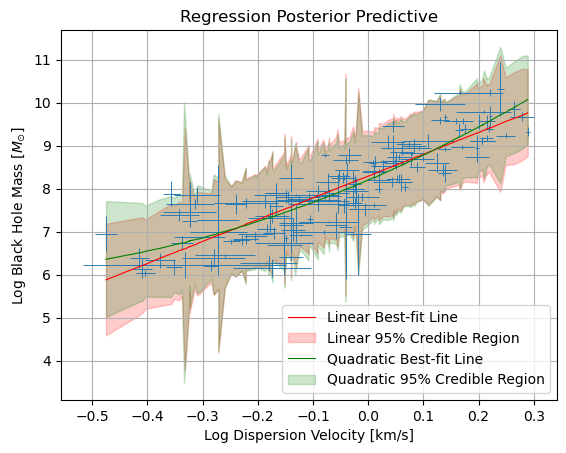

In [10]:
plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
             data['e_log_sigma'], fmt='none', elinewidth=0.66)

# Calculate quantiles for posterior predictive velocity dispersion for linear regression
X_l_mean = np.quantile(l_post_pred.posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
X_l_lower = np.quantile(l_post_pred.posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
X_l_upper = np.quantile(l_post_pred.posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]

# Calculate quantiles for posterior predictive black hole mass for linear regression
Y_l_mean = np.quantile(l_post_pred.posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
Y_l_lower = np.quantile(l_post_pred.posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
Y_l_upper = np.quantile(l_post_pred.posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))

# Plot mean and 95% confidence interval of posterior predictive for linear regression
plt.plot(X_l_mean, Y_l_mean, color='red', lw=0.8, label='Linear Best-fit Line')
plt.fill_between(X_l_mean, Y_l_lower, Y_l_upper, color='red',
                 alpha=0.2, label='Linear 95% Credible Region')

# Calculate quantiles for posterior predictive velocity dispersion for quadratic regression
X_q_mean = np.quantile(q_post_pred.posterior_predictive.X_obs.values, 0.50, axis=(0, 1))[:, 1]
X_q_lower = np.quantile(q_post_pred.posterior_predictive.X_obs.values, 0.025, axis=(0, 1))[:, 1]
X_q_upper = np.quantile(q_post_pred.posterior_predictive.X_obs.values, 0.975, axis=(0, 1))[:, 1]

# Calculate quantiles for posterior predictive black hole mass for quadratic regression
Y_q_mean = np.quantile(q_post_pred.posterior_predictive.Y_obs.values, 0.50, axis=(0, 1))
Y_q_lower = np.quantile(q_post_pred.posterior_predictive.Y_obs.values, 0.025, axis=(0, 1))
Y_q_upper = np.quantile(q_post_pred.posterior_predictive.Y_obs.values, 0.975, axis=(0, 1))

# Plot mean and 95% confidence interval of posterior predictive for quadratic regression
plt.plot(X_q_mean, Y_q_mean, color='green', lw=0.8, label='Quadratic Best-fit Line')
plt.fill_between(X_q_mean, Y_q_lower, Y_q_upper, color='green',
                 alpha=0.2, label='Quadratic 95% Credible Region')

plt.title('Regression Posterior Predictive')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.legend()
plt.grid()
plt.show()

# Sensitivity Analysis

### Regression varying c and d parameters

In [11]:
# Set c and d values to perform analysis over
c_opts = [1e-4, 1e-2, 1, 1e2]
d_opts = [1e-4, 1e-2, 1, 1e2]

cd_l_trace = [[0 for i in range(len(c_opts))] for j in range(len(d_opts))]
cd_l_prior_pred = cd_l_trace
cd_l_post_pred = cd_l_trace
cd_q_trace = [[0 for i in range(len(c_opts))] for j in range(len(d_opts))]
cd_q_prior_pred = cd_q_trace
cd_q_post_pred = cd_q_trace

for ii, c in enumerate(c_opts):
    for jj, d in enumerate(d_opts):
        # Linear regression varying parameters c and d
        _trace, _prior_pred, _post_pred = linear_regression(X_l, Y, X_l_err, Y_err,
                                                            c=c, d=d, samples=1000)
        cd_l_trace[ii][jj] = _trace
        cd_l_prior_pred[ii][jj] = _prior_pred
        cd_l_post_pred[ii][jj] = _post_pred
        
        # Quadratic regression varying parameters c and d
        _trace, _prior_pred, _post_pred = quadratic_regression(X_q, Y, X_q_err, Y_err,
                                                               c=c, d=d, samples=1000)
        cd_q_trace[ii][jj] = _trace
        cd_q_prior_pred[ii][jj] = _prior_pred
        cd_q_post_pred[ii][jj] = _post_pred

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

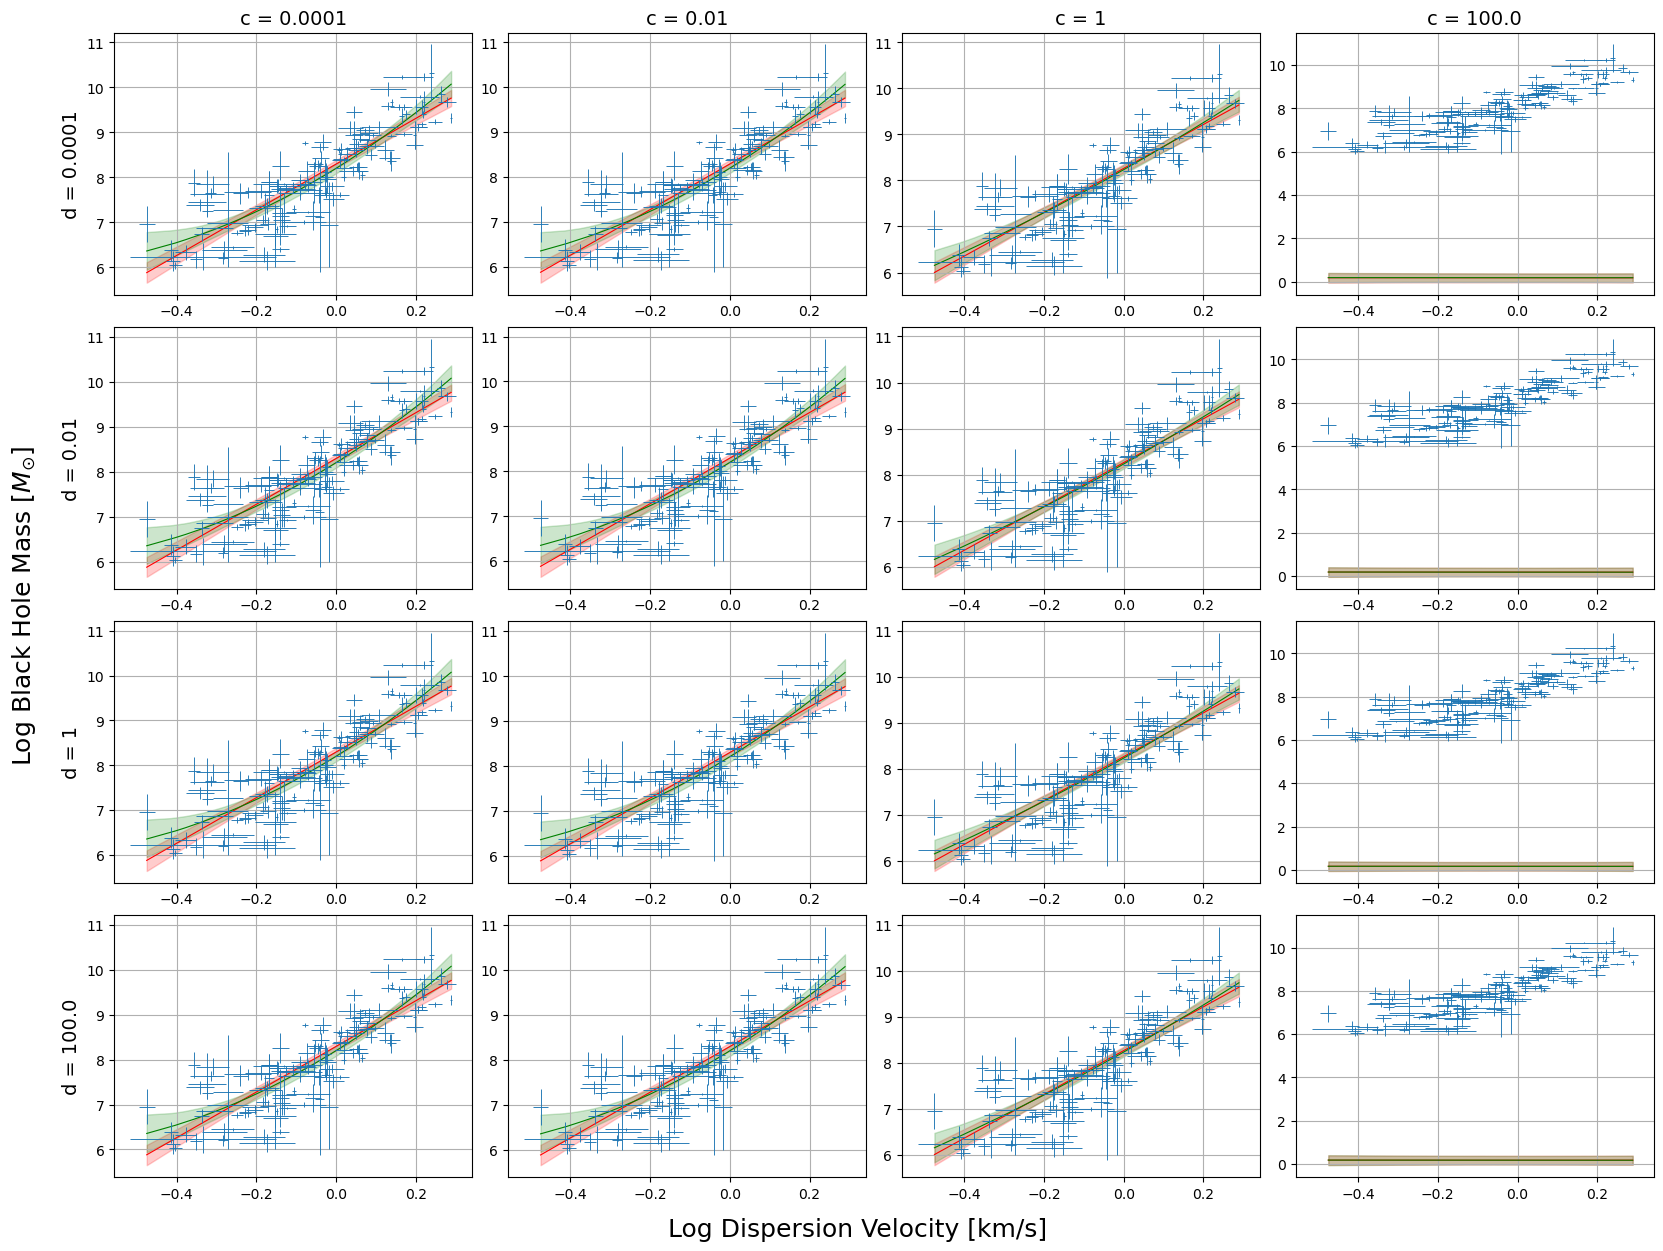

In [12]:
# Generate grid of plots varying c and d parameters
fig, ax = plt.subplots(len(c_opts), len(d_opts), layout='constrained', figsize=(16, 12))

for ii, c in enumerate(c_opts):
    for jj, d in enumerate(d_opts):
        # Calculate quantiles for posterior black hole mass data for linear regression
        _Y_l_mean = np.quantile(cd_l_trace[ii][jj].posterior.mu.values, 0.50, axis=(0, 1))
        _Y_l_lower = np.quantile(cd_l_trace[ii][jj].posterior.mu.values, 0.025, axis=(0, 1))
        _Y_l_upper = np.quantile(cd_l_trace[ii][jj].posterior.mu.values, 0.975, axis=(0, 1))

        # Plot mean and 95% confidence interval of posterior for linear regression
        ax[ii][jj].plot(data['log_sigma'], _Y_l_mean, color='red',
                        lw=0.8, label='Linear Best-fit Curve')
        ax[ii][jj].fill_between(data['log_sigma'], _Y_l_lower, _Y_l_upper, color='red',
                                alpha=0.2, label='Linear 95% Credible Region')

        # Calculate quantiles for posterior black hole mass data for quadratic regression
        _Y_q_mean = np.quantile(cd_q_trace[ii][jj].posterior.mu.values, 0.50, axis=(0, 1))
        _Y_q_lower = np.quantile(cd_q_trace[ii][jj].posterior.mu.values, 0.025, axis=(0, 1))
        _Y_q_upper = np.quantile(cd_q_trace[ii][jj].posterior.mu.values, 0.975, axis=(0, 1))

        # Plot mean and 95% confidence interval of posterior for quadratic regression
        ax[ii][jj].plot(data['log_sigma'], _Y_q_mean, color='green',
                        lw=0.8, label='Quadratic Best-fit Curve')
        ax[ii][jj].fill_between(data['log_sigma'], _Y_q_lower, _Y_q_upper, color='green',
                                alpha=0.2, label='Quadratic 95% Credible Region')

        # Overlay original dataset with errorbars
        ax[ii][jj].errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
                            data['e_log_sigma'], fmt='none', elinewidth=0.66)
        ax[ii][jj].grid()

# Set columns to be labeled with c parameter value
for axc, c in zip(ax[0], c_opts):
    axc.set_title(f'c = {c}', fontsize=14)

# Set rows to be labeled with d parameter value
for axd, d in zip(ax[:, 0], d_opts):
    axd.set_ylabel(f'd = {d}', fontsize=14)

fig.supxlabel(r'Log Dispersion Velocity [km/s]', fontsize=18, y=-0.03)
fig.supylabel(r'Log Black Hole Mass [$M_{\odot}$]', fontsize=18, x=-0.03)
plt.show()

### Regression varying e and f parameters

In [13]:
# Set e and f values to perform analysis over
e_opts = [5e-3, 5e-1, 5e1]
f_opts = [5e-3, 5e-1, 5e1]

ef_l_trace = [[0 for i in range(len(e_opts))] for j in range(len(f_opts))]
ef_l_prior_pred = ef_l_trace
ef_l_post_pred = ef_l_trace
ef_q_trace = [[0 for i in range(len(e_opts))] for j in range(len(f_opts))]
ef_q_prior_pred = ef_q_trace
ef_q_post_pred = ef_q_trace

for ii, e in enumerate(e_opts):
    for jj, f in enumerate(f_opts):
        # Linear regression varying parameters e and f
        _trace, _prior_pred, _post_pred = linear_regression(X_l, Y, X_l_err, Y_err,
                                                            e=e, f=f, samples=1000)
        ef_l_trace[ii][jj] = _trace
        ef_l_prior_pred[ii][jj] = _prior_pred
        ef_l_post_pred[ii][jj] = _post_pred
        
        # Quadratic regression varying parameters e and f
        _trace, _prior_pred, _post_pred = quadratic_regression(X_q, Y, X_q_err, Y_err,
                                                               e=e, f=f, samples=1000)
        ef_q_trace[ii][jj] = _trace
        ef_q_prior_pred[ii][jj] = _prior_pred
        ef_q_post_pred[ii][jj] = _post_pred

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, X_true, Y_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [X_obs, X_true, Y_obs, Y_true, beta, tau]
Sampling: [X_obs, Y_obs, Y_true]


Output()

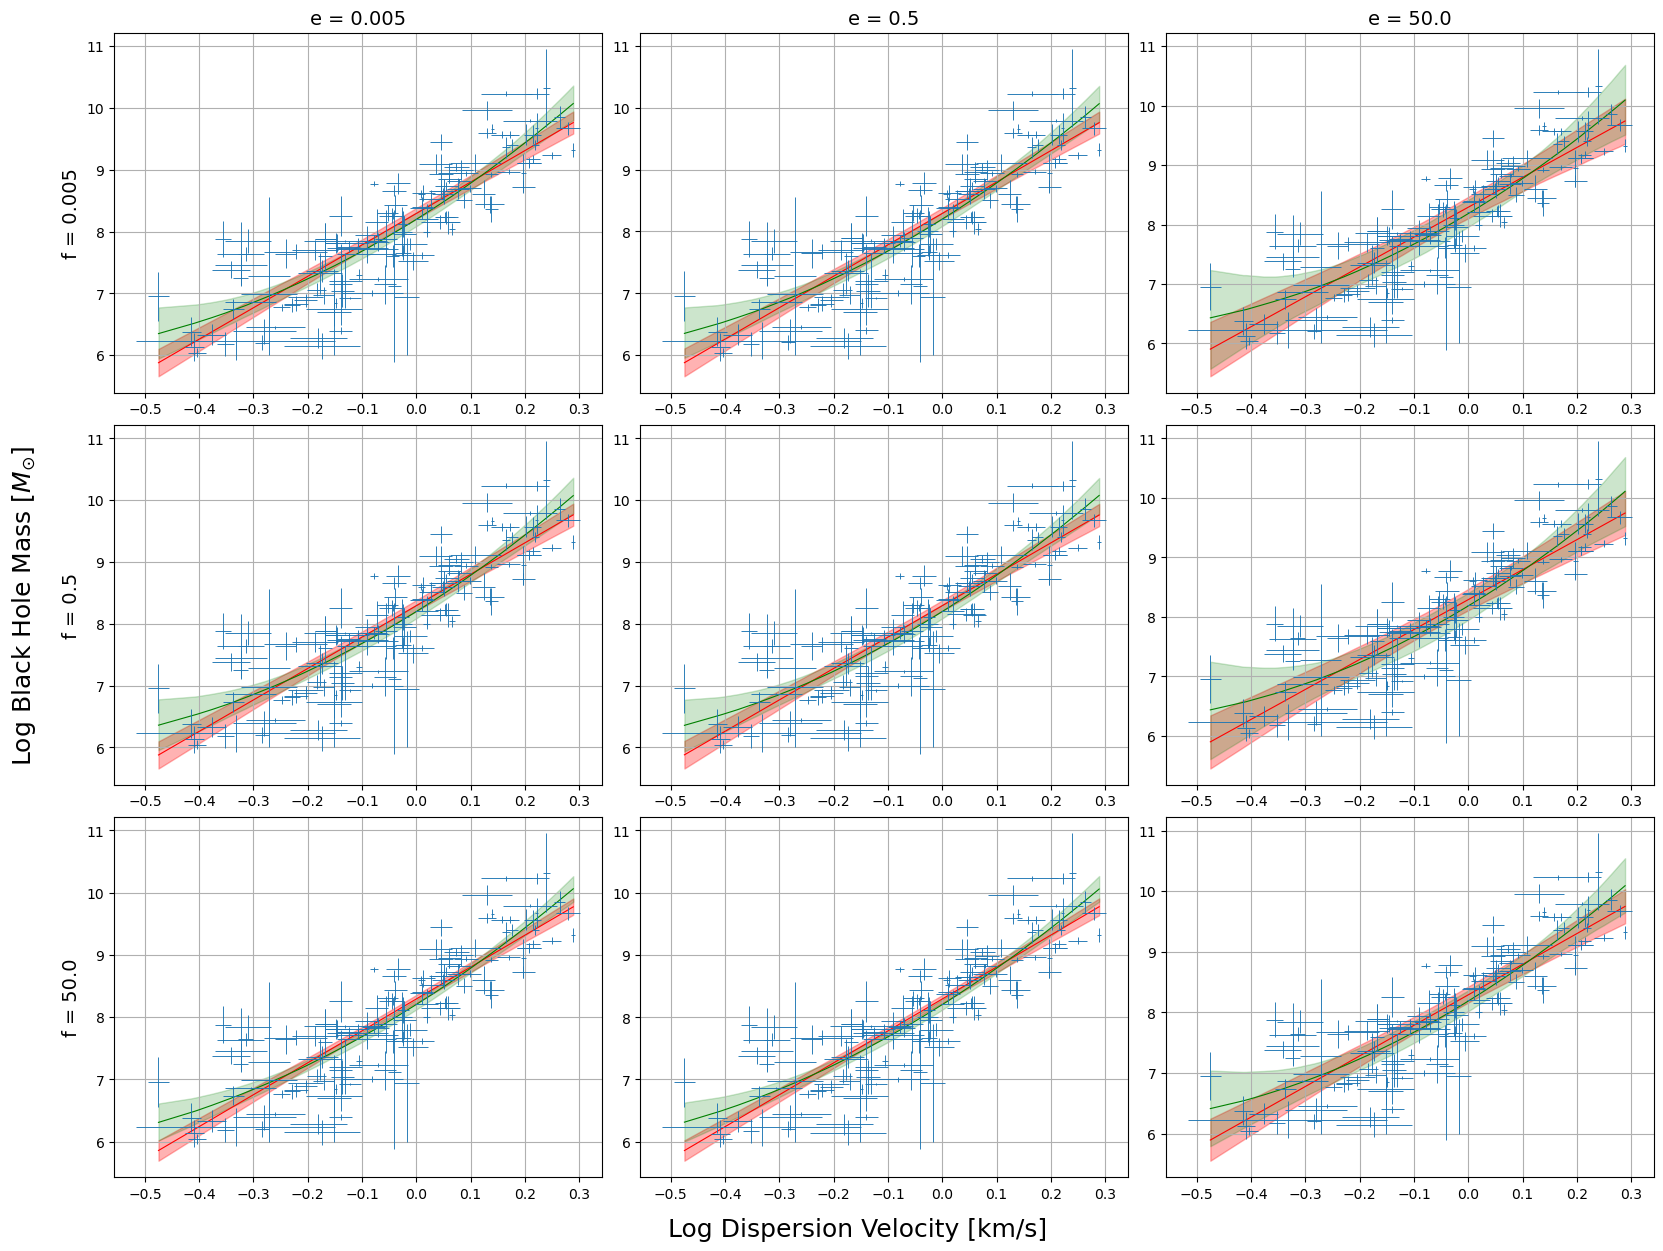

In [14]:
# Generate grid of plots varying e and f parameters
fig, ax = plt.subplots(len(e_opts), len(f_opts), layout='constrained', figsize=(16, 12))

for ii, c in enumerate(e_opts):
    for jj, d in enumerate(f_opts):
        # Calculate quantiles for posterior black hole mass data for linear regression
        _Y_l_mean = np.quantile(ef_l_trace[ii][jj].posterior.mu.values, 0.50, axis=(0, 1))
        _Y_l_lower = np.quantile(ef_l_trace[ii][jj].posterior.mu.values, 0.025, axis=(0, 1))
        _Y_l_upper = np.quantile(ef_l_trace[ii][jj].posterior.mu.values, 0.975, axis=(0, 1))

        # Plot mean and 95% confidence interval of posterior for linear regression
        ax[ii][jj].plot(data['log_sigma'], _Y_l_mean, color='red',
                        lw=0.8, label='Linear Best-fit Curve')
        ax[ii][jj].fill_between(data['log_sigma'], _Y_l_lower, _Y_l_upper, color='red',
                                alpha=0.3, label='Linear 95% Credible Region')

        # Calculate quantiles for posterior black hole mass data for quadratic regression
        _Y_q_mean = np.quantile(ef_q_trace[ii][jj].posterior.mu.values, 0.50, axis=(0, 1))
        _Y_q_lower = np.quantile(ef_q_trace[ii][jj].posterior.mu.values, 0.025, axis=(0, 1))
        _Y_q_upper = np.quantile(ef_q_trace[ii][jj].posterior.mu.values, 0.975, axis=(0, 1))

        # Plot mean and 95% confidence interval of posterior for quadratic regression
        ax[ii][jj].plot(data['log_sigma'], _Y_q_mean, color='green',
                        lw=0.8, label='Quadratic Best-fit Curve')
        ax[ii][jj].fill_between(data['log_sigma'], _Y_q_lower, _Y_q_upper, color='green',
                                alpha=0.2, label='Quadratic 95% Credible Region')

        # Overlay original dataset with errorbars
        ax[ii][jj].errorbar(data['log_sigma'], data['log_MassBH'], data['e_log_MassBH'],
                            data['e_log_sigma'], fmt='none', elinewidth=0.66)
        ax[ii][jj].grid()

# Set columns to be labeled with e parameter value
for axe, e in zip(ax[0], e_opts):
    axe.set_title(f'e = {e}', fontsize=14)

# Set rows to be labeled with f parameter value
for axf, f in zip(ax[:, 0], f_opts):
    axf.set_ylabel(f'f = {f}', fontsize=14)

fig.supxlabel(r'Log Dispersion Velocity [km/s]', fontsize=18, y=-0.03)
fig.supylabel(r'Log Black Hole Mass [$M_{\odot}$]', fontsize=18, x=-0.03)
plt.show()